# In this notebook we will use deep learing to colour in black and white photos

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import pandas
import PIL
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:1')

### For training we will use a dataset of animal photos from kaggle

In [2]:
# Data can be downloaded from https://www.kaggle.com/datasets/alessiocorrado99/animals10

# We need to apply transforms to the data. Here we tranform the image to a tensor then make
# sure everything is the same size.

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((512, 512), antialias=True)])
data_set = torchvision.datasets.ImageFolder("./archive/raw-img/", transform=transform)

### The network architecture that we will use is U-Net. This is a autoencoder like network with additional skip conections. More info can be found at the following reference https://arxiv.org/abs/1505.04597

In [3]:
class ConvBlock(torch.nn.Module):
    
    def __init__(self, in_dim, out_dim, filter_shape):
        super(ConvBlock, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_dim, out_dim, filter_shape, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_dim))
        
    def forward(self, x):
        return self.block(x)
    
    
class ColoUrNet(torch.nn.Module):
    
    def __init__(self):
        super(ColoUrNet, self).__init__()
        
        # Encoder blocks
        self.block_in_1 = torch.nn.Sequential(
            ConvBlock(1, 64, 3),
            ConvBlock(64, 64, 3))
        self.block_in_2 = torch.nn.Sequential(
            ConvBlock(64, 128, 3),
            ConvBlock(128, 128, 3))
        self.block_in_3 = torch.nn.Sequential(
            ConvBlock(128 , 256, 3),
            ConvBlock(256, 256, 3))
        self.block_in_4 = torch.nn.Sequential(
            ConvBlock(256 , 512, 3),
            ConvBlock(512, 512, 3))
        self.block_in_5 = torch.nn.Sequential(
            ConvBlock(512, 1024, 3),
            ConvBlock(1024, 1024, 3))
        
        # Encoder pooling
        self.pool_1 = torch.nn.MaxPool2d(2)
        self.pool_2 = torch.nn.MaxPool2d(2)
        self.pool_3 = torch.nn.MaxPool2d(2)
        self.pool_4 = torch.nn.MaxPool2d(2)

        # Decoder blocks
        self.block_out_1 = torch.nn.Sequential(
            ConvBlock(1024, 512, 3),
            ConvBlock(512, 512, 3))
        self.block_out_2 = torch.nn.Sequential(
            ConvBlock(512, 256, 3),
            ConvBlock(256, 256, 3))
        self.block_out_3 = torch.nn.Sequential(
            ConvBlock(256, 128, 3),
            ConvBlock(128, 128, 3))
        self.block_out_4 = torch.nn.Sequential(
            ConvBlock(128, 64, 3),
            ConvBlock(64, 64, 3))
        
        # Decoder unpooling
        self.unpool_1 = torch.nn.ConvTranspose2d(1024, 512, 3, 2, padding = 1, output_padding=1)
        self.unpool_2 = torch.nn.ConvTranspose2d(512, 256, 3, 2, padding = 1, output_padding=1)
        self.unpool_3 = torch.nn.ConvTranspose2d(256, 128, 3, 2, padding = 1, output_padding=1)
        self.unpool_4 = torch.nn.ConvTranspose2d(128, 64, 3, 2, padding = 1, output_padding=1)
        
        # Output layer
        self.ouput = torch.nn.Conv2d(64, 3, 1, padding='same')
    
    def forward(self, x):
        bi1 = self.block_in_1(x)
        bi2 = self.block_in_2(self.pool_1(bi1))
        bi3 = self.block_in_3(self.pool_2(bi2))
        bi4 = self.block_in_4(self.pool_3(bi3))
        bi5 = self.block_in_5(self.pool_4(bi4))
        
        bo1 = torch.cat([self.unpool_1(bi5), bi4], 1)
        bo2 = torch.cat([self.unpool_2(self.block_out_1(bo1)), bi3], 1)
        bo3 = torch.cat([self.unpool_3(self.block_out_2(bo2)), bi2], 1)
        bo4 = torch.cat([self.unpool_4(self.block_out_3(bo3)), bi1], 1)
        bo5 = self.block_out_4(bo4)
        return self.ouput(bo5)

        
        
        return self.network(x)

In [4]:
# Setup the data loader / network / optimiser / loss function / scheduler

# Network
network = ColoUrNet()
network.to(device)

# Data loader
dataLoader = DataLoader(data_set, batch_size=16, shuffle=True, num_workers=8)

# Using adam optimiser
optim = torch.optim.Adam(network.parameters(), 1e-3)

# We will use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10000, eta_min = 1e-5)

# Simple MSE loss function
def loss_fn(net_out, image_out):
    mse_loss = torch.mean((net_out - image_out)**2)
    return mse_loss

ColoUrNet(
  (block_in_1): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (block_in_2): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(128,

### Now for the training loop. This takes a long time even with a good GPU. Skip the next couple cells and load the pretrained model if you want to skip this.

In [7]:

# For saving metrics during training
losses = []
learning_rates = []
writer = SummaryWriter()

# We apply a grey-scale trandform to the input of the netowk
grey_trans = torchvision.transforms.Grayscale()

epochs = 100
for i in range(epochs):
    network.train()

    for j, in_image in enumerate(dataLoader):
        # Get data and move to device
        in_image, out_image = grey_trans(in_image[0].to(device)), in_image[0].to(device)
        
        # Forward pass and get loss
        net_out = network(in_image)
        loss = loss_fn(net_out, out_image)
        
        #calculate gradients
        loss.backward()
        
        losses.append(loss.item()) 
        learning_rates.append(optim.param_groups[0]['lr'])
        
        # Take gradient step and learning rate step
        optim.step()
        scheduler.step()
        
        # Reset gradients
        optim.zero_grad()
        
        # Add to tensorboard
        writer.add_scalar("Loss/train", loss.item(), len(dataLoader) * i + j)
        writer.add_scalar("lr/train", optim.param_groups[0]['lr'], len(dataLoader) * i + j)

    

    # After each epoch we'll check how the network is doing on a butterfly picture
    network.eval()
    with torch.no_grad():
        image_in, _ = data_set[9003]
        image_in = grey_trans(image_in.to(device))
        net_out = network(image_in[None, :, :, :])[0]
        
        fig, ax = plt.subplots()
        ax.imshow(net_out.cpu().numpy().transpose((1,2,0)))
        writer.add_figure('my_figure_batch', fig, i)

        
        print(j, losses[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.007551707327365875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.008284349925816059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.009804447181522846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.007204713765531778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.021661289036273956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0030073155649006367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.016550205647945404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005078688729554415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.04699670895934105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.009412731043994427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.01736960932612419


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005934605840593576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.004798347596079111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005980027373880148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.020691027864813805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0055841789580881596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.022155506536364555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.015719596296548843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005230769515037537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.014194480143487453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.08033708482980728


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.010095884092152119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.011526373215019703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.03052724152803421


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005017629824578762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.008500797674059868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.014476370997726917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.011234951205551624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0034630459267646074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0583316870033741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.021018177270889282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.01136645209044218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.009913001209497452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.03466234728693962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.008247933350503445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.008175494149327278


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.006647415459156036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.009023429825901985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0025309838820248842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.008172896690666676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.010667815804481506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.00782663282006979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.012232551351189613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.011034498922526836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005717325955629349


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.004007326904684305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.011897957883775234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.002498443704098463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.013638106174767017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.01694892905652523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.003535345196723938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.010123198851943016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.00293961470015347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.02129548043012619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.005412215832620859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.0064473203383386135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.01614011637866497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.01048306655138731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.002201141556724906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.007401532493531704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.004640160594135523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.013309781439602375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.006343130487948656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.006788500119000673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.009261107072234154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.025323374196887016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.004332616925239563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1636 0.006430258043110371


KeyboardInterrupt: 

In [8]:
# Now save the model so it can be used later (skip this if you just want to use pre-saved form)
torch.save(network.state_dict(), "./Models/coloUrNet.pth")

In [ ]:
# This cell loads the pre-trained network
network = ColoUrNet()
network.load_state_dict(torch.load("./Models/coloUrNet.pth"))
network.eval()

### Now lets finally look at a couple of examples, staring with some in-set examples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)


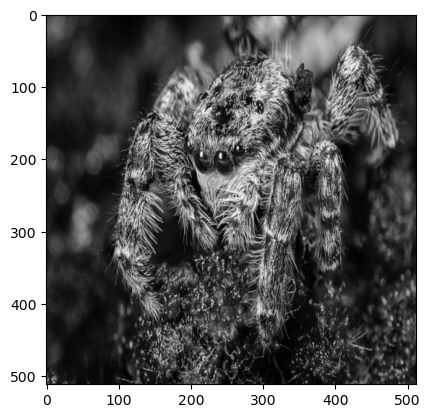

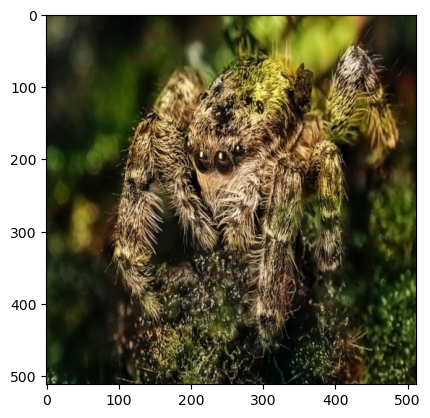

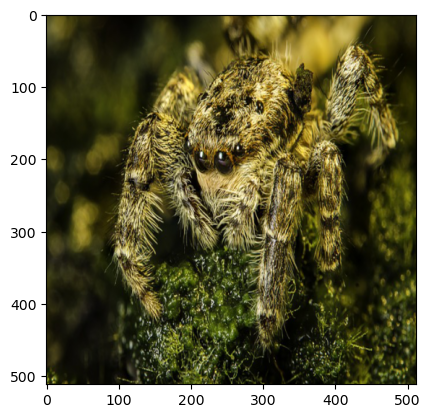

In [29]:
sample_num = 24000

network.eval()
with torch.no_grad():
    im_in_c, _ = data_set[sample_num]
    im_in = grey_trans(im_in_c.to(device))
    net_out = network(im_in[None, :, :, :])[0]
im_in = np.squeeze(im_in.cpu().numpy())
print(im_in.shape)
im_ratio = np.squeeze(net_out.cpu().numpy()).transpose(1, 2, 0)
fig = plt.figure(1)
plt.imshow(im_in, cmap="gray")
fig = plt.figure(2)
plt.imshow(net_out.cpu().numpy().transpose((1,2,0)))
plt.show()
fig = plt.figure(3)

plt.imshow(im_in_c.cpu().numpy().transpose((1,2,0)))
plt.show()

### Finally lets Check out the network does with some unseen pictures

In [13]:
test_input = PIL.Image.open("./example/input_test.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)


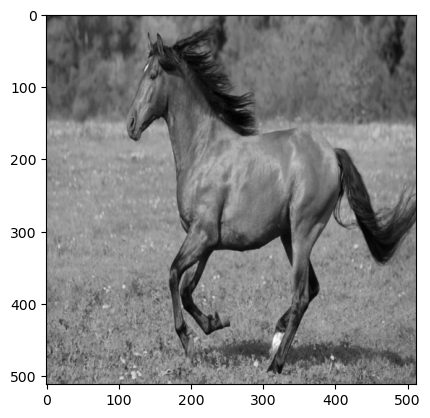

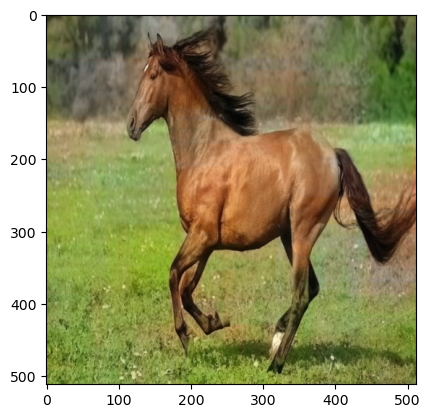

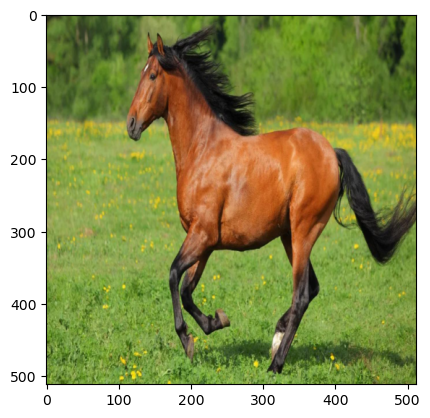

In [14]:
network.eval()
with torch.no_grad():
    im_in_c = transform(test_input)
    im_in = grey_trans(im_in_c.to(device))
    net_out = network(im_in[None, :, :, :])[0]
im_in = np.squeeze(im_in.cpu().numpy())
print(im_in.shape)
im_ratio = np.squeeze(net_out.cpu().numpy()).transpose(1, 2, 0)
fig = plt.figure(1)
plt.imshow(im_in, cmap="gray")
fig = plt.figure(2)
plt.imshow(net_out.cpu().numpy().transpose((1,2,0)))
plt.show()
fig = plt.figure(3)

plt.imshow(im_in_c.cpu().numpy().transpose((1,2,0)))
plt.show()